In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

import scipy.io

from sbi.inference import infer, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import pickle
from sbi.analysis import pairplot

In [2]:
def FACTS(theta):
    ini='DesignC_AUKF_onlinepertdelay_SBI.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.dim() > 1:
#             pdb.set_trace()
            print(theta.numel())
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
            
            config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
            config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
            config['ArticStateEstimator']['process_scale'] = str(theta[0][4].item())
            config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

            config['SensoryDelay']['Auditory_delay'] = str(theta[0][6].item())
            config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())
            config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[0][8].item())
            
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[0][6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[0][7].item())
            
        else:
#             pdb.set_trace()
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
            
            config['TaskStateEstimator']['process_scale'] = str(theta[2].item())
            config['TaskStateEstimator']['covariance_scale'] = str(theta[3].item())
            config['ArticStateEstimator']['process_scale'] = str(theta[4].item())
            config['ArticStateEstimator']['covariance_scale'] = str(theta[5].item())

            config['SensoryDelay']['Auditory_delay'] = str(theta[6].item())
            config['SensoryDelay']['Somato_delay'] = str(theta[7].item())
            config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[8].item())
            
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[7].item())
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    x_tilde_delaywindow = np.full([20,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([20,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+20,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+20,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+20,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        #print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        #print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            if (formants_produced == -1).all():
                formants_produced_record[i_frm:] = [-1, -1, -1]
                a_tilde_record[i_frm:] = np.tile(-10000, 12)
                x_tilde_record[i_frm:] = np.tile(-10000, 14)
                break
            else:
                a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                formants_produced_record[i_frm] = formants_produced 
            
        
        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)
        
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return formants_produced_record_alltrials[:,:,0].squeeze() 


## Test that FACTS works

In [ ]:
test_theta = torch.from_numpy(np.array([0.0188, 0.05, 2.4, 2.6, 0.0000001, 0.0000001, 100, 50, 4]))
simulated_test = FACTS(original_theta)
x_time = np.linspace(-200,500, num=150)
plt.plot(x_time, simulated_test)

### Run an example trial, or do a parameter sweep

#### Auditory noise scale:

Low: 0.0001

High: 0.04


#### Somatosensory noise scale:

Low: .002

High: 1


#### TSE Process Scale:

Low: 0.0001

High: 5


#### TSE Covariance Scale:

Low: 0.0000001

High: 5

#### ASE Process Scale:

Low: 10e-12

High: 10e-6


#### ASE Covariance Scale:

Low: 10e-12

High: 10e-4


#### SensoryDelay Auditory Delay:

Low: 20

High: 105

#### SensoryDelay Somato Delay:

Low: 45

High: 105

#### TSE estimated_auditory_delay:

Low: 10 

High: 105

#### ASE estimated_somat_delay

Low: 10 

High: 30

#### cc_discount


### Load Parell's data to see what it looks like

In [3]:
# import observed data
trial_cells = scipy.io.loadmat('sbi_resources/parrell_2017/magnitudes.mat')

In [4]:
trial_cells['magnitudes'].dtype

dtype([('ACUp', 'O'), ('ACDown', 'O'), ('HOCUp', 'O'), ('HOCDown', 'O'), ('all', 'O'), ('group', 'O'), ('direction', 'O'), ('subjID', 'O'), ('ACBaseline', 'O'), ('HOCBaseline', 'O')])

In [5]:
print(trial_cells['magnitudes']['ACBaseline'][0,0].shape)
print(trial_cells['magnitudes']['HOCBaseline'][0,0].shape)

(172, 1900)
(172, 1354)


### Print some of these data to see what it looks like

(172, 613)
(172, 672)
(172, 378)
(172, 528)


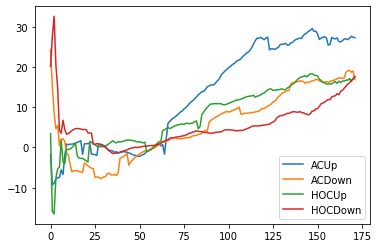

In [6]:
items = ['ACUp', 'ACDown', 'HOCUp', 'HOCDown']

for item in items:
    print(trial_cells['magnitudes'][item][0,0].shape) # Print shape of array
    avg_ACUp = np.nanmean(trial_cells['magnitudes'][item][0,0],1) # Get nanmean of array

    plt.plot(avg_ACUp, label=item)
    
plt.legend()

## See what the other data look like

In [7]:
data_healthy_2019 = scipy.io.loadmat('sbi_resources/parrell_2019/fmtMatrix_shiftUpshiftDown_merged_OA.mat')
print(data_healthy_2019.keys())

dict_keys(['__header__', '__version__', '__globals__', 'tstep', 'dataPaths', 'ffx', 'rfx', 'bMels', 'bFilt', 'linecolors'])


In [8]:
print(data_healthy_2019['ffx']['rawf1'][0,0]['shiftUp'][0,0].shape)
print(data_healthy_2019['ffx']['rawf1'][0,0]['shiftDown'][0,0].shape)
print(data_healthy_2019['rfx']['rawf1'][0,0]['shiftUp'][0,0].shape)
print(data_healthy_2019['rfx']['rawf1'][0,0]['shiftDown'][0,0].shape)
print(data_healthy_2019['ffx']['rawf1'][0,0].dtype)

(307, 413)
(313, 409)
(307, 14)
(313, 14)
[('noShiftdead', 'O'), ('noShiftfed', 'O'), ('noShiftsaid', 'O'), ('noShiftshed', 'O'), ('shiftUp', 'O'), ('shiftDown', 'O')]


#### Plot healthy data

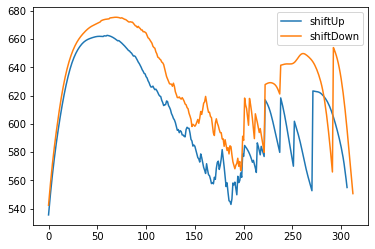

In [9]:
healthy_ffx_shiftUp = data_healthy_2019['ffx']['rawf1'][0,0]['shiftUp'][0,0]
healthy_ffx_shiftDown = data_healthy_2019['ffx']['rawf1'][0,0]['shiftDown'][0,0]

# print(healthy_ffx_shiftUp)
plt.plot(np.nanmean(healthy_ffx_shiftUp,1), label='shiftUp' )
plt.plot(np.nanmean(healthy_ffx_shiftDown,1), label='shiftDown' )
plt.legend()

#### Plot CD Data

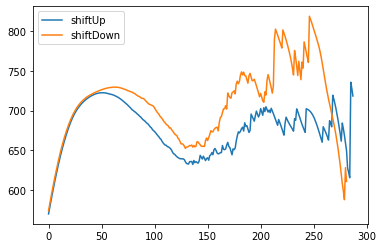

In [10]:
data_CD_2019 = scipy.io.loadmat('sbi_resources/parrell_2019/fmtMatrix_shiftUpshiftDown_merged_CD.mat')

CD_ffx_shiftUp = data_CD_2019['ffx']['rawf1'][0,0]['shiftUp'][0,0]
CD_ffx_shiftDown = data_CD_2019['ffx']['rawf1'][0,0]['shiftDown'][0,0]

plt.plot(np.nanmean(CD_ffx_shiftUp,1), label='shiftUp' )
plt.plot(np.nanmean(CD_ffx_shiftDown,1), label='shiftDown' )
plt.legend()

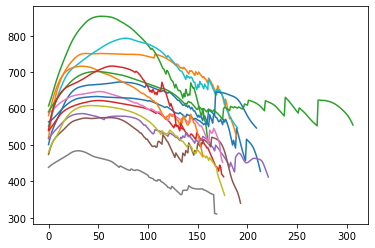

In [11]:
healthy_subj_means_shiftUp = data_healthy_2019['rfx']['rawf1'][0,0]['shiftUp'][0,0]
plt.plot(healthy_subj_means_shiftUp, label='subjs_shiftUp')

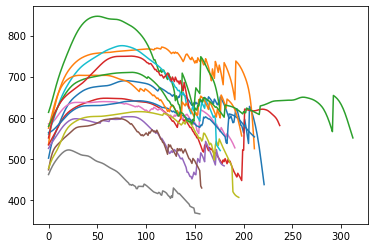

In [12]:
healthy_subj_means_shiftDown = data_healthy_2019['rfx']['rawf1'][0,0]['shiftDown'][0,0]
plt.plot(healthy_subj_means_shiftDown, label='subjs_shiftDown')

(1, 194)
(1797, 194)
(1, 150)
(1797, 150)


Text(0.5, 1.0, 'Mean real observations N:1797')

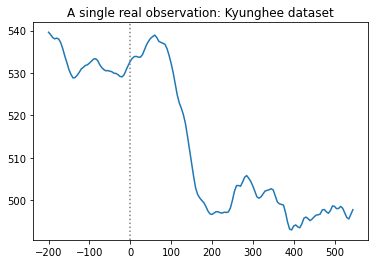

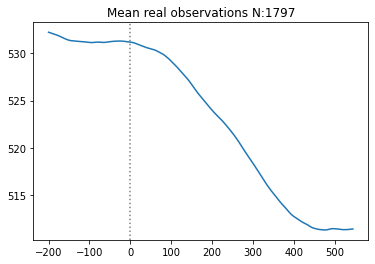

In [13]:
# Import real observed data
# trial_cells_times = scipy.io.loadmat('sbi_resources/parrell_2017/magnitudes.mat')
# trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T # 1797 x 194 == trials by time

trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_time_cleaned.mat')['time_matrix'].T
trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T 

print(trial_cells_times.shape)
print(trial_cells_mat.shape)
trial_cells_times = trial_cells_times[:,0:150]
trial_cells_mat = trial_cells_mat[:,0:150]
print(trial_cells_times.shape)
print(trial_cells_mat.shape)

# # Alter the trial_cells so that they center to where FACTS centers
trial_cells_mat = trial_cells_mat + 531

# Plot and compare observed data to FACTS data
plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[729,:])
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title('A single real observation: Kyunghee dataset')
# plt.ylim([510,535])

plt.figure()
plt.plot(trial_cells_times[0,:]*1000, np.mean(trial_cells_mat, 0))
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title(f'Mean real observations N:{(trial_cells_mat.shape[0])}')
# plt.ylim([510,535])

# # # Now realign so that 
# plt.figure()
# plt.title('FACTS')
# example_x = (np.arange(len(example))*5)-200
# plt.plot(example_x,example)
# plt.axvline(x = 0, color = 'grey', ls=':')
# plt.xlabel('Time (ms)')
# plt.ylabel('F1 HZ')
# # plt.ylim([510,535])

## Test if original theta leads to paper results

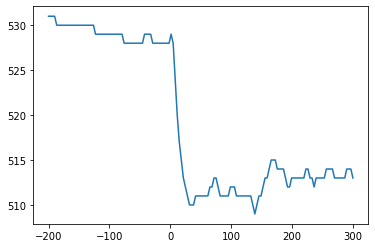

In [14]:
x_time = np.linspace(-200,300, num=150)
original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3]))
formant_test = FACTS(original_theta)
plt.plot(x_time, formant_test)

In [15]:
print(np.min(trial_cells_mat[729,:]))
print(np.min(np.mean(trial_cells_mat, 0)))
# print(np.min(example))

493.03972341681293
511.3030736359036


In [16]:

# import facts_for_SBI

load_instead = True

#Auditory noise scale:
# Low: 0.0001
# High: 0.04
#Somatosensory noise scale:
# Low: .002
# High: 1
#TSE Process Scale:
# Low: 0.0001
# High: 5
#TSE Covariance Scale:
# Low: 0.0000001
# High: 5
#ASE Process Scale:
# Low: 10e-12
# High: 10e-6
#ASE Covariance Scale:
# Low: 10e-12
# High: 10e-4
#SensoryDelay Auditory Delay:
# Low: 20
# High: 105
#SensoryDelay Somato Delay:
# Low: 45
# High: 105
#CC_reduction_from_delay
# Low: 20
# High: 60

# import your simulator, define your prior over the parameters
#prior_mean = 0.002
prior_min= [0.0001, 0.002, 0.0001, 0.0000001, 10e-12, 10e-12, 20, 20, 1]
prior_mmax = [0.04, 1.0, 5, 5, 10e-6, 10e-4, 105, 105, 60] 
num_sim = 1000
num_workers = 6

prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior)
    
# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
if load_instead == False:    
    theta, x = simulate_for_sbi(simulator2, proposal=prior, num_simulations=num_sim, num_workers=num_workers)
    #parameter_posterior = infer(simulator2, prior, method='SNPE', num_simulations=num_sim, num_workers=num_workers)
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator)
    
    # Save the theta and x
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_theta_x_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([theta, x], f)
    # Save the posterior
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([posterior], f)
    
else:
    # Get list of all pickle files matching string
    all_files = os.listdir('./sbi_resources')
    selected_files = [x for x in all_files if 'cc_reduction_from_delay_theta_x_100' in x]
    
    # Iterate through list
    all_theta, all_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
    for file_string in selected_files:
        file = open(f'./sbi_resources/{file_string}', 'rb')
        this_theta, this_x = pickle.load(file)

        # Append 
        all_theta = torch.cat((all_theta, this_theta))
        all_x = torch.cat((all_x, this_x))
    
        # Close file
        file.close()    
    print(all_theta.shape)
    print(all_x.shape)

18
torch.Size([240342, 9])
torch.Size([240342, 150])


#### Get density and posterior estimations

In [17]:
all_theta[0][0]

tensor(0.0062)

In [18]:
density_estimator = inference.append_simulations(all_theta, all_x).train(force_first_round_loss=True) # Look more into force_first_round_loss=True
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 195 epochs.

## Sample the posterior for a single point from Kyunghee's observations

In [19]:
# object_file = pickle.load(file)
# parameter_posterior = object_file[0]
# file.close()
    
# print(single_trial.shape)
# print()

In [20]:
mean_trials = np.mean(trial_cells_mat, 0)
single_trial = trial_cells_mat[729]

## Sample the posterior for the mean of all trials

In [21]:
labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
          'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
          'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay']

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

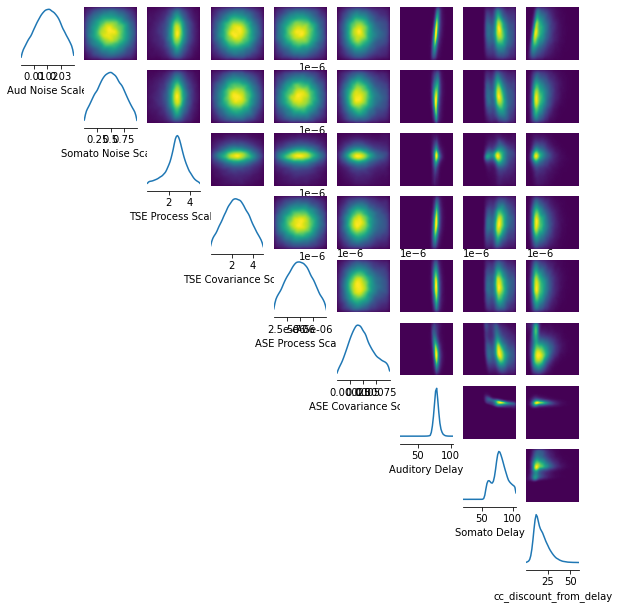

In [22]:
samples = posterior.sample((100000,), x=mean_trials)
log_probability = posterior.log_prob(samples, x=mean_trials)
out = pairplot(samples, fig_size=(10,10), upper='kde', diag='kde', labels=labels)

## Now grab the max of each marginal, simulate, and calculate RMSE

torch.Size([100000, 9])
[2.0747442e-02 4.9595276e-01 2.8165734e+00 2.4607832e+00 4.8917841e-06
 4.4793566e-04 7.8131668e+01 7.9719177e+01 1.5859976e+01]


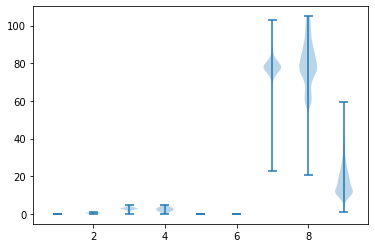

In [23]:
print(samples.shape)
samples[:,0].shape
print(np.median(samples,0))

plt.violinplot(samples.T)
posterior_medians = np.median(samples,0)

tensor([2.0747e-02, 4.9595e-01, 2.8166e+00, 2.4608e+00, 4.8918e-06, 4.4794e-04,
        7.8132e+01, 7.9719e+01, 1.5860e+01])
torch.Size([9])


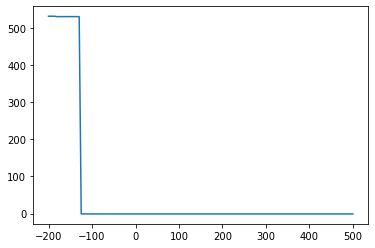

In [24]:
posterior_medians = torch.from_numpy(np.nanmedian(samples,0))
print(posterior_medians)
print(posterior_medians.shape)
simulated_formant = FACTS(posterior_medians)
x_time = np.linspace(-200,500, num=150)

plt.plot(x_time, simulated_formant)

## Test if original theta leads to what the paper published

# Plot for a single trial

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

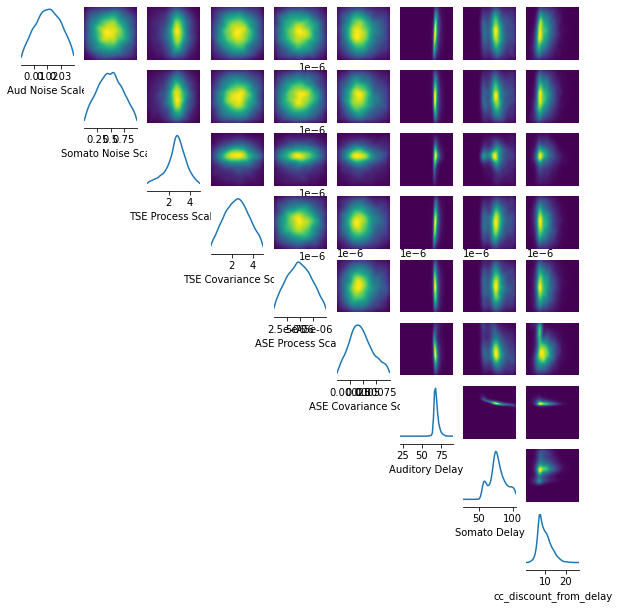

In [25]:
single_trial = trial_cells_mat[729]

samples_single_trial = posterior.sample((10000,), x=single_trial)
# log_probability = posterior.log_prob(samples, x=single_trial)
out = pairplot(samples_single_trial, fig_size=(10,10), upper='kde', diag='kde', labels=labels)

tensor([2.0551e-02, 4.9375e-01, 2.7433e+00, 2.4904e+00, 4.8708e-06, 4.6299e-04,
        6.8412e+01, 7.7951e+01, 9.8000e+00])
torch.Size([9])


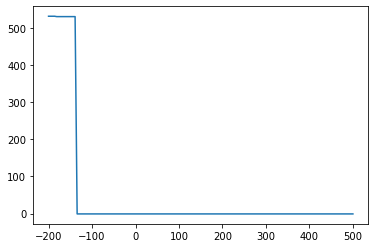

In [26]:
posterior_medians_st = torch.from_numpy(np.nanmean(samples_single_trial,0))
print(posterior_medians_st)
print(posterior_medians_st.shape)
simulated_formant_st = FACTS(posterior_medians_st)
x_time = np.linspace(-200,500, num=150)

plt.plot(x_time, simulated_formant_st)

## Test which variables are breaking the simulation

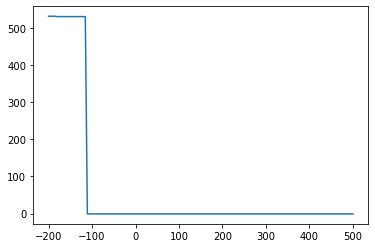

In [29]:
#tensor([1.84e-02, 5.13e-01, 2.43e+00, 2.63e+00, 4.96e-06, 5.17e-04, 8.37e+01, 6.42e+01, 4.22e+01])
original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3]))
# test_theta = torch.from_numpy(np.array([0.0188, 0.05, 2.4, 2.6, 0.0000001, 0.0000001, 100, 50, 4]))
simulated_test = FACTS(original_theta)
x_time = np.linspace(-200,500, num=150)
plt.plot(x_time, simulated_test)

The auditory and somato delays break the simulation

If auditory delay goes from 100 to 94, then the simulation breaks

In [28]:
posterior_argmax = torch.from_numpy(np.argmax(samples_single_trial,0))
print(posterior_argmax)
print(posterior_argmax.shape)
simulated_argmax = FACTS(posterior_argmax)
x_time = np.linspace(-200,500, num=150)

plt.plot(x_time, simulated_argmax)

TypeError: expected np.ndarray (got Tensor)